## Creation of figures

The two cells below are used to create figure 2 of the paper. The first cell executes the algorithms on the datasets und then computes the "optimal" classification based on the computed classes. 
Both algorithms output an integer representing a color for each node and each iteration. The sNP algorithm is implemented slightly differently than described in the paper. The outcomes are equivalent though.

In [1]:
import torch
import torch_geometric
from torchmetrics.utilities.data import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import main

iterations = 10
# arrays for storing the number of classes and overlap score for each iteration and each dataset
wl_len_accumulated = []
np_len_accumulated = []
wl_overlap_accumulated = []
np_overlap_accumulated = []

for dataset_path in ['ENZYMES', 'NCI1', 'MUTAG']:
    # convertion from torch_geometric data to one networkx graph
    dataset = torch_geometric.datasets.TUDataset('~/datasets', dataset_path)
    dataset = torch_geometric.data.Batch.from_data_list(list(dataset))
    dataset.y = to_categorical(dataset.x)
    g1 = torch_geometric.utils.to_networkx(dataset, node_attrs=['x','y'],to_undirected=True)

    # execution of the algorithms both return a final coloring and an array of colors after each iteration. 
    wl = main.weisfeiler_lehman(g1, iterations=iterations, early_stopping=False)
    npr = main.np_refinement(g1, iterations=iterations)

    # compute the relative number of color classes with respect to dataset size. 
    wl_len = [len(wl[2][i])/len(g1) for i in range(iterations+1)]
    wl_len_accumulated.extend(wl_len)
    npr_len = [len(set(npr[1][i]))/len(g1) for i in range(iterations+1)]
    np_len_accumulated.extend(npr_len)

    for i in range(iterations+1):
        # compute the unique colors for each iteration. The inverse arrays are later used to index the component for the specific color.
        unique_wl, inv_wl = np.unique(wl[3][i], return_inverse=True)
        unique_np, inv_np = np.unique(npr[1][i], return_inverse=True)

        # initialize the arrays to count how for each target label, how many nodes have which class. 
        same_occurance_array_wl = np.zeros((len(g1.nodes()[0]['x']),len(unique_wl)))
        same_occurance_array_np = np.zeros((len(g1.nodes()[0]['x']),len(unique_np)))

        # for each node, add 1 to the component with the color and target label of the node.
        for node in g1.nodes():
            same_occurance_array_wl[np.argmax(g1.nodes()[node]['x']), inv_wl[node]] += 1
            same_occurance_array_np[np.argmax(g1.nodes()[node]['x']), inv_np[node]] += 1

        # within each color class, classify the whole class as the most probable target. 
        wl_acc = np.sum([np.max(same_occurance_array_wl[:,role]) for role in range(len(unique_wl))])
        wl_acc = wl_acc/len(g1)
        if (i == 0):
            baseline = wl_acc
        wl_overlap = (wl_acc-baseline)/(1-baseline)
        wl_overlap_accumulated.append(wl_overlap)

        npr_acc = np.sum([np.max(same_occurance_array_np[:,role]) for role in range(len(unique_np))])
        npr_acc = npr_acc/len(g1)
        if (i == 0):
            baseline = npr_acc
        npr_overlap = (npr_acc-baseline)/(1-baseline)
        np_overlap_accumulated.append(npr_overlap)

print(wl_len_accumulated, np_len_accumulated, wl_overlap_accumulated, np_overlap_accumulated)


[5.107252298263534e-05, 0.0005107252298263534, 0.045965270684371805, 0.6110827374872319, 0.763585291113381, 0.8062308478038815, 0.8280388151174668, 0.8406026557711951, 0.8489274770173647, 0.854902962206333, 0.8593462717058222, 8.14683861927379e-06, 4.073419309636895e-05, 0.0005539850261106178, 0.017181682648048424, 0.1191149274524021, 0.2888054290532559, 0.4219899468011438, 0.5123302402502709, 0.576519181731529, 0.622996896054486, 0.6559834456239256, 0.0002966478789676654, 0.0011865915158706616, 0.005636309700385643, 0.03826757638682884, 0.19074458617620885, 0.36220706021951943, 0.49213883120735685, 0.5716404627706911, 0.6063482646099081, 0.6202907149213883, 0.625927024621774] [5.107252298263534e-05, 0.0005107252298263534, 0.18600612870275793, 0.6821246169560776, 0.770582226762002, 0.8086312563840654, 0.8294177732379979, 0.8414198161389173, 0.8495403472931563, 0.8558222676200204, 0.8597037793667007, 8.14683861927379e-06, 4.073419309636895e-05, 0.0006354534123033556, 0.01408588397272438

After execution of the above, the len_accumulated and overlap_accumulated arrays store the respective data. We simply plot this using matplotlib:

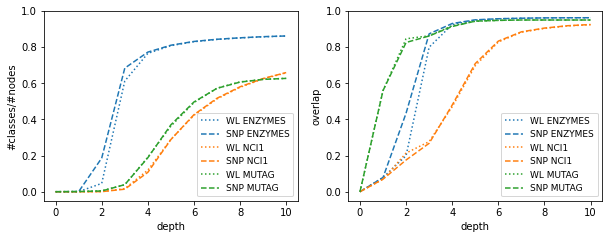

In [2]:
plt.figure(figsize=(10,3.5), frameon=False)
plt.subplot(1,2,1)
plt.plot(range(iterations+1), wl_len_accumulated[:iterations+1], color='tab:blue', linestyle='dotted', label='WL ENZYMES')
plt.plot(range(iterations+1), np_len_accumulated[:iterations+1], color='tab:blue', linestyle='dashed', label='SNP ENZYMES')
plt.plot(range(iterations+1), wl_len_accumulated[iterations+1:2*(iterations+1)], color='tab:orange', linestyle='dotted', label='WL NCI1')
plt.plot(range(iterations+1), np_len_accumulated[iterations+1:2*(iterations+1)], color='tab:orange', linestyle='dashed', label='SNP NCI1')
plt.plot(range(iterations+1), wl_len_accumulated[2*(iterations+1):3*(iterations+1)], color='tab:green', linestyle='dotted', label='WL MUTAG')
plt.plot(range(iterations+1), np_len_accumulated[2*(iterations+1):3*(iterations+1)], color='tab:green', linestyle='dashed', label='SNP MUTAG')
plt.xlabel("depth")
plt.ylabel("#classes/#nodes")
plt.ylim([-.05,1])
plt.legend(loc='lower right', prop={'size':9})
plt.subplot(1,2,2)
plt.plot(range(iterations+1), wl_overlap_accumulated[:iterations+1], color='tab:blue', linestyle='dotted', label='WL ENZYMES')
plt.plot(range(iterations+1), np_overlap_accumulated[:iterations+1], color='tab:blue', linestyle='dashed', label='SNP ENZYMES')
plt.plot(range(iterations+1), wl_overlap_accumulated[iterations+1:2*(iterations+1)], color='tab:orange', linestyle='dotted', label='WL NCI1')
plt.plot(range(iterations+1), np_overlap_accumulated[iterations+1:2*(iterations+1)], color='tab:orange', linestyle='dashed', label='SNP NCI1')
plt.plot(range(iterations+1), wl_overlap_accumulated[2*(iterations+1):3*(iterations+1)], color='tab:green', linestyle='dotted', label='WL MUTAG')
plt.plot(range(iterations+1), np_overlap_accumulated[2*(iterations+1):3*(iterations+1)], color='tab:green', linestyle='dashed', label='SNP MUTAG')
plt.ylim([-0.05,1])
plt.xlabel("depth")
plt.ylabel("overlap")
plt.legend(loc='lower right', prop={'size':9})
plt.show()